# COMP3065 Computer Vision Coursework
@author: Gaole Dai (20124917)

@email: scygd1@nottingham.edu.cn

@file: image search with encoder and decoder (CNN) for feature extraction

@cite: code partially from https://github.com/oke-aditya/image_similarity

## Mount Drive

In [ ]:
!nvidia-smi
from google.colab import drive
drive.mount('/content/drive')

## Prerequisites

In [ ]:
import os
import pandas as pd
import numpy as np
from numpy.testing import assert_almost_equal
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from tqdm import tqdm
from torch.utils.data import Dataset

from torchvision import transforms
import torch.optim as optim
from torchvision.io import read_image


if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

## Images Resize

In [ ]:
inputDim = (224, 224)
input_path = '/content/drive/MyDrive/y4_cv/oxbuild_images_100'
output_path = '/content/drive/MyDrive/y4_cv/oxbuild_images_100_new'

os.makedirs(output_path, exist_ok = True)

img_transformation = transforms.Compose([transforms.Resize(inputDim)])

for image_name in os.listdir(input_path):
    img = Image.open(os.path.join(input_path, image_name))
    new_img = img_transformation(img)

    # # copy the rotation information metadata from original image and save, else your transformed images may be rotated
    # exif = img.info['exif']
    new_img.save(os.path.join(output_path, image_name))
    
    new_img.close()
    img.close()

## Dataset Preparation and DataLoader

In [ ]:
labels_map = {
    0: "all-souls",
    1: "ashmolean",
    2: "balliol",
    3: "bodleian",
    4: "christ church",
    5: "cornmarket",
    6: "hertford",
    7: "keble",
    8: "magdalen",
    9: "pitt rivers",
    10: "radcliffe camera"
}

all_imgs = []

class OxfordBuilding(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.img_dir = '/content/drive/MyDrive/y4_cv/oxbuild_images_100_new'
        self.transform = transform
        self.target_transform = target_transform
        self.all_imgs = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.all_imgs[idx])
        image = read_image(img_path)
        if self.transform:
          image = self.transform(image)
        return image, image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.4814, 0.4865, 0.4683], [0.2736, 0.2776, 0.3152])
])

oxford5k_dataset = OxfordBuilding(transform=transform)
test_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and test splits:
dataset_size = len(oxford5k_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
print(dataset_size)

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(oxford5k_dataset, batch_size=32, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(oxford5k_dataset, batch_size=16, sampler=test_sampler)
full_loader = torch.utils.data.DataLoader(oxford5k_dataset, batch_size=dataset_size, shuffle=False)

# """
# # Calculate the std and mean
# def batch_mean_and_sd(loader):
#     cnt = 0
#     fst_moment = torch.empty(3)
#     snd_moment = torch.empty(3)

#     for images, _ in loader:
#         b, c, h, w = images.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(images, dim=[0, 2, 3])
#         sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
#         cnt += nb_pixels

#     mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
#     return mean,std
  
# mean, std = batch_mean_and_sd(train_loader)
# print("mean and std: \n", mean, std)
# """



## Autoencoder Model Initial

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
      super().__init__()
      # self.img_size = img_size
      self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
      self.relu1 = nn.ReLU(inplace=True)
      self.maxpool1 = nn.MaxPool2d((2, 2))

      self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
      self.relu2 = nn.ReLU(inplace=True)
      self.maxpool2 = nn.MaxPool2d((2, 2))

      self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
      self.relu3 = nn.ReLU(inplace=True)
      self.maxpool3 = nn.MaxPool2d((2, 2))

      self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
      self.relu4 = nn.ReLU(inplace=True)
      self.maxpool4 = nn.MaxPool2d((2, 2))

  def forward(self, x):
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.maxpool1(x)

      x = self.conv2(x)
      x = self.relu2(x)
      x = self.maxpool2(x)

      x = self.conv3(x)
      x = self.relu3(x)
      x = self.maxpool3(x)

      x = self.conv4(x)
      x = self.relu4(x)
      x = self.maxpool4(x)

      return x


class Decoder(nn.Module):
  def __init__(self):
      super().__init__()
      self.deconv1 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2))
      self.relu1 = nn.ReLU(inplace=True)

      self.deconv2 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
      self.relu2 = nn.ReLU(inplace=True)

      self.deconv3 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
      self.relu3 = nn.ReLU(inplace=True)

      self.deconv4 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
      self.relu4 = nn.ReLU(inplace=True)

  def forward(self, x):
      x = self.deconv1(x)
      x = self.relu1(x)

      x = self.deconv2(x)
      x = self.relu2(x)

      x = self.deconv3(x)
      x = self.relu3(x)
      
      x = self.deconv4(x)
      x = self.relu4(x)
      return x

## Training

In [ ]:
def train_step(encoder, decoder, loss_fn, optimizer, device):
    encoder.train()
    decoder.train()

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()

        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = loss_fn(dec_output, target_img)
        loss.backward()

        optimizer.step()

    return loss.item()


def test_step(encoder, decoder, loss_fn, device):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
      for batch_idx, (train_img, target_img) in enumerate(test_loader):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = loss_fn(dec_output, target_img)

    return loss.item()

loss_fn = nn.MSELoss()

encoder = Encoder()
decoder = Decoder()

encoder.to(device)
decoder.to(device)

autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.AdamW(autoencoder_params, lr=0.0001)

max_loss = 9999

print("------------ Training started ------------")

for epoch in tqdm(range(60)):
    train_loss = train_step(
        encoder, decoder, loss_fn, optimizer, device=device
    )
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")
    test_loss = test_step(
        encoder, decoder, loss_fn, device=device
    )

    # Simple Best Model saving
    if test_loss < max_loss:
        print("Validation Loss decreased, saving new best model")
        torch.save(encoder.state_dict(), '/content/drive/MyDrive/y4_cv/encoder_100_2.pth')
        torch.save(decoder.state_dict(), '/content/drive/MyDrive/y4_cv/decoder_100_2.pth')

    print(f"Epochs = {epoch}, Validation Loss : {test_loss}")

print("Training Done")

------------ Training started ------------


  2%|▏         | 1/60 [00:00<00:38,  1.52it/s]

Epochs = 0, Training Loss : 1.1769288778305054
Validation Loss decreased, saving new best model
Epochs = 0, Validation Loss : 1.358479619026184


  3%|▎         | 2/60 [00:01<00:37,  1.53it/s]

Epochs = 1, Training Loss : 1.0360420942306519
Validation Loss decreased, saving new best model
Epochs = 1, Validation Loss : 0.9337274432182312


  5%|▌         | 3/60 [00:01<00:36,  1.56it/s]

Epochs = 2, Training Loss : 0.9493885636329651
Validation Loss decreased, saving new best model
Epochs = 2, Validation Loss : 0.7064384818077087


  7%|▋         | 4/60 [00:02<00:35,  1.56it/s]

Epochs = 3, Training Loss : 0.9802041053771973
Validation Loss decreased, saving new best model
Epochs = 3, Validation Loss : 0.8019694685935974


  8%|▊         | 5/60 [00:03<00:35,  1.57it/s]

Epochs = 4, Training Loss : 0.9604898691177368
Validation Loss decreased, saving new best model
Epochs = 4, Validation Loss : 0.6782839894294739


 10%|█         | 6/60 [00:03<00:34,  1.57it/s]

Epochs = 5, Training Loss : 1.1303119659423828
Validation Loss decreased, saving new best model
Epochs = 5, Validation Loss : 0.7356651425361633


 12%|█▏        | 7/60 [00:04<00:34,  1.55it/s]

Epochs = 6, Training Loss : 0.8500983715057373
Validation Loss decreased, saving new best model
Epochs = 6, Validation Loss : 1.0051929950714111


 13%|█▎        | 8/60 [00:05<00:33,  1.53it/s]

Epochs = 7, Training Loss : 1.1455010175704956
Validation Loss decreased, saving new best model
Epochs = 7, Validation Loss : 0.5422710180282593


 15%|█▌        | 9/60 [00:05<00:32,  1.55it/s]

Epochs = 8, Training Loss : 0.9551317691802979
Validation Loss decreased, saving new best model
Epochs = 8, Validation Loss : 1.296929955482483


 17%|█▋        | 10/60 [00:06<00:32,  1.55it/s]

Epochs = 9, Training Loss : 1.0898479223251343
Validation Loss decreased, saving new best model
Epochs = 9, Validation Loss : 0.6889517903327942


 18%|█▊        | 11/60 [00:07<00:31,  1.56it/s]

Epochs = 10, Training Loss : 1.1794058084487915
Validation Loss decreased, saving new best model
Epochs = 10, Validation Loss : 0.5272114276885986


 20%|██        | 12/60 [00:07<00:30,  1.58it/s]

Epochs = 11, Training Loss : 0.9102850556373596
Validation Loss decreased, saving new best model
Epochs = 11, Validation Loss : 0.9359034299850464


 22%|██▏       | 13/60 [00:08<00:29,  1.59it/s]

Epochs = 12, Training Loss : 0.8965799808502197
Validation Loss decreased, saving new best model
Epochs = 12, Validation Loss : 1.049389362335205


 23%|██▎       | 14/60 [00:08<00:29,  1.58it/s]

Epochs = 13, Training Loss : 1.0872150659561157
Validation Loss decreased, saving new best model
Epochs = 13, Validation Loss : 0.5614520311355591


 25%|██▌       | 15/60 [00:09<00:28,  1.58it/s]

Epochs = 14, Training Loss : 0.9761599898338318
Validation Loss decreased, saving new best model
Epochs = 14, Validation Loss : 1.3279545307159424


 27%|██▋       | 16/60 [00:10<00:27,  1.58it/s]

Epochs = 15, Training Loss : 0.8137714862823486
Validation Loss decreased, saving new best model
Epochs = 15, Validation Loss : 0.9141326546669006


 28%|██▊       | 17/60 [00:10<00:27,  1.56it/s]

Epochs = 16, Training Loss : 0.990770697593689
Validation Loss decreased, saving new best model
Epochs = 16, Validation Loss : 1.2213870286941528


 30%|███       | 18/60 [00:11<00:26,  1.57it/s]

Epochs = 17, Training Loss : 0.89134281873703
Validation Loss decreased, saving new best model
Epochs = 17, Validation Loss : 0.8479008078575134


 32%|███▏      | 19/60 [00:12<00:25,  1.58it/s]

Epochs = 18, Training Loss : 0.9282653331756592
Validation Loss decreased, saving new best model
Epochs = 18, Validation Loss : 0.9158439040184021


 33%|███▎      | 20/60 [00:12<00:25,  1.59it/s]

Epochs = 19, Training Loss : 0.7694005966186523
Validation Loss decreased, saving new best model
Epochs = 19, Validation Loss : 1.0661722421646118


 35%|███▌      | 21/60 [00:13<00:24,  1.59it/s]

Epochs = 20, Training Loss : 0.6991163492202759
Validation Loss decreased, saving new best model
Epochs = 20, Validation Loss : 0.9786401391029358


 37%|███▋      | 22/60 [00:13<00:23,  1.60it/s]

Epochs = 21, Training Loss : 0.8448572158813477
Validation Loss decreased, saving new best model
Epochs = 21, Validation Loss : 0.913299560546875


 38%|███▊      | 23/60 [00:14<00:23,  1.59it/s]

Epochs = 22, Training Loss : 0.6806065440177917
Validation Loss decreased, saving new best model
Epochs = 22, Validation Loss : 0.9561824202537537


 40%|████      | 24/60 [00:15<00:22,  1.57it/s]

Epochs = 23, Training Loss : 0.6851530075073242
Validation Loss decreased, saving new best model
Epochs = 23, Validation Loss : 0.7379301190376282


 42%|████▏     | 25/60 [00:15<00:22,  1.56it/s]

Epochs = 24, Training Loss : 0.65604168176651
Validation Loss decreased, saving new best model
Epochs = 24, Validation Loss : 0.6264894604682922


 43%|████▎     | 26/60 [00:16<00:21,  1.57it/s]

Epochs = 25, Training Loss : 0.7953199148178101
Validation Loss decreased, saving new best model
Epochs = 25, Validation Loss : 0.7658494114875793


 45%|████▌     | 27/60 [00:17<00:21,  1.54it/s]

Epochs = 26, Training Loss : 0.7341738343238831
Validation Loss decreased, saving new best model
Epochs = 26, Validation Loss : 0.7762447595596313


 47%|████▋     | 28/60 [00:17<00:20,  1.55it/s]

Epochs = 27, Training Loss : 0.8176873922348022
Validation Loss decreased, saving new best model
Epochs = 27, Validation Loss : 0.812581479549408


 48%|████▊     | 29/60 [00:18<00:19,  1.55it/s]

Epochs = 28, Training Loss : 0.724194347858429
Validation Loss decreased, saving new best model
Epochs = 28, Validation Loss : 0.5421579480171204


 50%|█████     | 30/60 [00:19<00:19,  1.56it/s]

Epochs = 29, Training Loss : 0.74153733253479
Validation Loss decreased, saving new best model
Epochs = 29, Validation Loss : 0.9590979218482971


 52%|█████▏    | 31/60 [00:19<00:19,  1.50it/s]

Epochs = 30, Training Loss : 0.6919498443603516
Validation Loss decreased, saving new best model
Epochs = 30, Validation Loss : 0.5867549180984497


 53%|█████▎    | 32/60 [00:20<00:20,  1.40it/s]

Epochs = 31, Training Loss : 0.7575203776359558
Validation Loss decreased, saving new best model
Epochs = 31, Validation Loss : 0.6568015813827515


 55%|█████▌    | 33/60 [00:21<00:20,  1.31it/s]

Epochs = 32, Training Loss : 0.8336359858512878
Validation Loss decreased, saving new best model
Epochs = 32, Validation Loss : 0.8295354247093201


 57%|█████▋    | 34/60 [00:22<00:20,  1.27it/s]

Epochs = 33, Training Loss : 0.7017313241958618
Validation Loss decreased, saving new best model
Epochs = 33, Validation Loss : 0.5454431176185608


 58%|█████▊    | 35/60 [00:23<00:23,  1.08it/s]

Epochs = 34, Training Loss : 0.7203704118728638
Validation Loss decreased, saving new best model
Epochs = 34, Validation Loss : 0.7656652331352234


 60%|██████    | 36/60 [00:24<00:21,  1.12it/s]

Epochs = 35, Training Loss : 0.7250149250030518
Validation Loss decreased, saving new best model
Epochs = 35, Validation Loss : 0.665871798992157


 62%|██████▏   | 37/60 [00:25<00:20,  1.15it/s]

Epochs = 36, Training Loss : 0.5765400528907776
Validation Loss decreased, saving new best model
Epochs = 36, Validation Loss : 0.6531555652618408


 63%|██████▎   | 38/60 [00:26<00:18,  1.20it/s]

Epochs = 37, Training Loss : 0.7744556069374084
Validation Loss decreased, saving new best model
Epochs = 37, Validation Loss : 0.6797937750816345


 65%|██████▌   | 39/60 [00:26<00:17,  1.21it/s]

Epochs = 38, Training Loss : 0.6263590455055237
Validation Loss decreased, saving new best model
Epochs = 38, Validation Loss : 0.36356857419013977


 67%|██████▋   | 40/60 [00:27<00:16,  1.23it/s]

Epochs = 39, Training Loss : 0.7760974764823914
Validation Loss decreased, saving new best model
Epochs = 39, Validation Loss : 0.58829265832901


 68%|██████▊   | 41/60 [00:28<00:14,  1.32it/s]

Epochs = 40, Training Loss : 0.7110247015953064
Validation Loss decreased, saving new best model
Epochs = 40, Validation Loss : 0.5767792463302612


 70%|███████   | 42/60 [00:28<00:13,  1.36it/s]

Epochs = 41, Training Loss : 0.6443507671356201
Validation Loss decreased, saving new best model
Epochs = 41, Validation Loss : 0.9272691011428833


 72%|███████▏  | 43/60 [00:29<00:12,  1.32it/s]

Epochs = 42, Training Loss : 0.5414543747901917
Validation Loss decreased, saving new best model
Epochs = 42, Validation Loss : 0.42704179883003235


 73%|███████▎  | 44/60 [00:30<00:12,  1.26it/s]

Epochs = 43, Training Loss : 0.6060205101966858
Validation Loss decreased, saving new best model
Epochs = 43, Validation Loss : 0.37912702560424805


 75%|███████▌  | 45/60 [00:31<00:11,  1.29it/s]

Epochs = 44, Training Loss : 0.7531417608261108
Validation Loss decreased, saving new best model
Epochs = 44, Validation Loss : 0.7796121835708618


 77%|███████▋  | 46/60 [00:32<00:11,  1.26it/s]

Epochs = 45, Training Loss : 0.7217385768890381
Validation Loss decreased, saving new best model
Epochs = 45, Validation Loss : 0.722289502620697


 78%|███████▊  | 47/60 [00:32<00:10,  1.26it/s]

Epochs = 46, Training Loss : 0.7315003871917725
Validation Loss decreased, saving new best model
Epochs = 46, Validation Loss : 0.38111600279808044


 80%|████████  | 48/60 [00:33<00:08,  1.35it/s]

Epochs = 47, Training Loss : 0.7900620698928833
Validation Loss decreased, saving new best model
Epochs = 47, Validation Loss : 0.4208175837993622


 82%|████████▏ | 49/60 [00:34<00:07,  1.41it/s]

Epochs = 48, Training Loss : 0.6624614000320435
Validation Loss decreased, saving new best model
Epochs = 48, Validation Loss : 0.6106336712837219


 83%|████████▎ | 50/60 [00:34<00:06,  1.47it/s]

Epochs = 49, Training Loss : 0.7219433188438416
Validation Loss decreased, saving new best model
Epochs = 49, Validation Loss : 0.5499094724655151


 85%|████████▌ | 51/60 [00:35<00:05,  1.51it/s]

Epochs = 50, Training Loss : 0.6619699001312256
Validation Loss decreased, saving new best model
Epochs = 50, Validation Loss : 0.5589917898178101


 87%|████████▋ | 52/60 [00:36<00:05,  1.53it/s]

Epochs = 51, Training Loss : 0.6762659549713135
Validation Loss decreased, saving new best model
Epochs = 51, Validation Loss : 0.5570446252822876


 88%|████████▊ | 53/60 [00:36<00:04,  1.55it/s]

Epochs = 52, Training Loss : 0.7032783627510071
Validation Loss decreased, saving new best model
Epochs = 52, Validation Loss : 0.35654351115226746


 90%|█████████ | 54/60 [00:37<00:03,  1.56it/s]

Epochs = 53, Training Loss : 0.5723686814308167
Validation Loss decreased, saving new best model
Epochs = 53, Validation Loss : 0.44719719886779785


 92%|█████████▏| 55/60 [00:38<00:03,  1.57it/s]

Epochs = 54, Training Loss : 0.6426882147789001
Validation Loss decreased, saving new best model
Epochs = 54, Validation Loss : 0.46048128604888916


 93%|█████████▎| 56/60 [00:38<00:02,  1.57it/s]

Epochs = 55, Training Loss : 0.6112037897109985
Validation Loss decreased, saving new best model
Epochs = 55, Validation Loss : 0.4144134819507599


 95%|█████████▌| 57/60 [00:39<00:01,  1.58it/s]

Epochs = 56, Training Loss : 0.5920906662940979
Validation Loss decreased, saving new best model
Epochs = 56, Validation Loss : 0.42474564909935


 97%|█████████▋| 58/60 [00:39<00:01,  1.58it/s]

Epochs = 57, Training Loss : 0.6439881920814514
Validation Loss decreased, saving new best model
Epochs = 57, Validation Loss : 0.7014924883842468


 98%|█████████▊| 59/60 [00:40<00:00,  1.58it/s]

Epochs = 58, Training Loss : 0.6335839033126831
Validation Loss decreased, saving new best model
Epochs = 58, Validation Loss : 0.5509131550788879


100%|██████████| 60/60 [00:41<00:00,  1.46it/s]

Epochs = 59, Training Loss : 0.5653037428855896
Validation Loss decreased, saving new best model
Epochs = 59, Validation Loss : 0.4893498718738556
Training Done


## Feature Extraction

In [ ]:
model_encoder = Encoder()
model_encoder.load_state_dict(
    torch.load('/content/drive/MyDrive/y4_cv/encoder_100_2.pth'))
model_encoder.to(device)

embedding_dim = (1, 128, 14, 14)
def create_embedding(encoder, full_loader, embedding_dim, device):
  encoder.eval()
  embedding = torch.randn(embedding_dim).to(device)

  with torch.no_grad():
    for batch_idx, (train_img, target_img) in enumerate(full_loader):
        train_img = train_img.to(device)
        enc_output = encoder(train_img).to(device)
        embedding = torch.cat((embedding, enc_output), 0)
  return embedding

embedding = create_embedding(model_encoder, full_loader, embedding_dim, device)
numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]

flattened_embedding = numpy_embedding.reshape((num_images, -1))

## Compute Similar Images

In [ ]:
def compute_similar_images(model, image_tensor, num_images, embedding, device):
  image_tensor = image_tensor.to(device)

  with torch.no_grad():
    image_embedding = model(image_tensor).cpu().detach().numpy()

  flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))

  knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")

  knn.fit(embedding)

  _, indices = knn.kneighbors(flattened_embedding)
  indices_list = indices.tolist()
  # print(indices_list)
  return indices_list

img_names = oxford5k_dataset.all_imgs

all_vectors = {}
for image in tqdm(os.listdir('/content/drive/MyDrive/y4_cv/oxbuild_images_100_new')):
    img = Image.open(os.path.join('/content/drive/MyDrive/y4_cv/oxbuild_images_100_new', image))
    image_tensor = transforms.ToTensor()(img)
    image_tensor = image_tensor.unsqueeze(0)
    indices_list = compute_similar_images(
        model_encoder, image_tensor, 4, embedding=flattened_embedding, device=device
    )
    all_vectors[image] = [img_names[(indices_list[0][0]-1)], img_names[(indices_list[0][1]-1)], 
                img_names[(indices_list[0][2]-1)], img_names[(indices_list[0][3]-1)]]
    img.close()
print(all_vectors)
with open('/content/drive/MyDrive/y4_cv/cbir_similar_vectors_100_2.pkl', 'wb') as f:
  pickle.dump(all_vectors, f)

100%|██████████| 189/189 [00:09<00:00, 20.46it/s]

{'all_souls_000140.jpg': ['radcliffe_camera_000034.jpg', 'bodleian_000108.jpg', 'christ_church_000932.jpg', 'all_souls_000140.jpg'], 'all_souls_000091.jpg': ['all_souls_000006.jpg', 'christ_church_000932.jpg', 'radcliffe_camera_000034.jpg', 'christ_church_000228.jpg'], 'all_souls_000075.jpg': ['oxford_000962.jpg', 'bodleian_000298.jpg', 'all_souls_000075.jpg', 'radcliffe_camera_000034.jpg'], 'all_souls_000068.jpg': ['radcliffe_camera_000034.jpg', 'all_souls_000068.jpg', 'bodleian_000108.jpg', 'bodleian_000298.jpg'], 'all_souls_000055.jpg': ['radcliffe_camera_000034.jpg', 'christ_church_000757.jpg', 'magdalen_000078.jpg', 'magdalen_000504.jpg'], 'all_souls_000040.jpg': ['radcliffe_camera_000034.jpg', 'magdalen_000504.jpg', 'christ_church_000932.jpg', 'all_souls_000006.jpg'], 'all_souls_000015.jpg': ['bodleian_000108.jpg', 'magdalen_000560.jpg', 'magdalen_000504.jpg', 'christ_church_000228.jpg'], 'all_souls_000026.jpg': ['christ_church_000228.jpg', 'christ_church_000078.jpg', 'ashmolean_

## Option 2 for Image Cluster

In [ ]:
def create_embedding(image, encoder, device):
    encoder.eval()
    with torch.no_grad():
      toTensor = transforms.ToTensor()
      image = toTensor(image).unsqueeze(0).to(device)
      # embedding = torch.zeros(1, self.features_number, 1, 1)

      def copyData(m, i, o): embedding.copy_(o.data)
      embedding = encoder(image).to(device)
      # embedding = torch.cat((embedding, enc_output), 0)
      # print(embedding.shape)
    return embedding.cpu().detach().numpy()[0, :, 0, 0]
    

all_vectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir('/content/drive/MyDrive/y4_cv/oxbuild_images_100_new')):
    img = Image.open(os.path.join('/content/drive/MyDrive/y4_cv/oxbuild_images_100_new', image))
    vec = create_embedding(img, encoder, device)
    all_vectors[image] = vec
    img.close()

Converting images to feature vectors:


100%|██████████| 189/189 [00:00<00:00, 255.54it/s]


In [ ]:
def get_similarity_matrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    return matrix

similarity_matrix = get_similarity_matrix(all_vectors)

k = 5 # the number of top similar images to be stored

similar_names = pd.DataFrame(index = similarity_matrix.index, columns = range(k))
similar_values = pd.DataFrame(index = similarity_matrix.index, columns = range(k))

for j in tqdm(range(similarity_matrix.shape[0])):
  k_similar = similarity_matrix.iloc[j, :].sort_values(ascending = False).head(k)
  similar_names.iloc[j, :] = list(k_similar.index)
  similar_values.iloc[j, :] = k_similar.values
    
similar_names.to_pickle('/content/drive/MyDrive/y4_cv/similar_names_model4.pkl')
similar_values.to_pickle('/content/drive/MyDrive/y4_cv/similar_values_model4.pkl')

100%|██████████| 189/189 [00:00<00:00, 2230.52it/s]


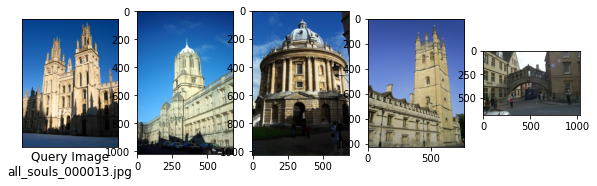

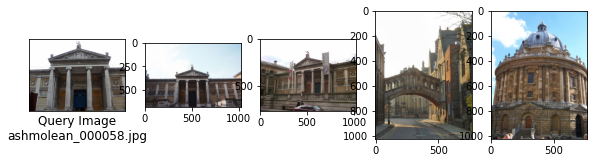

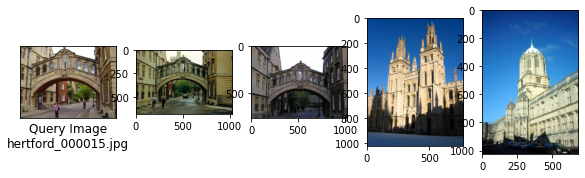

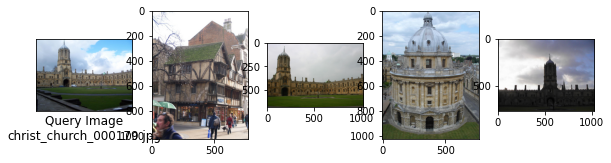

In [ ]:
inputImages = ["all_souls_000013.jpg", "ashmolean_000058.jpg", "hertford_000015.jpg", "christ_church_000179.jpg"]

numCol = 5
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format(image, value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def get_similar_images(image, simNames, simVals):
    if image in set(simNames.index):
      imgs = list(simNames.loc[image, :])
      vals = list(simVals.loc[image, :])
      if image in imgs:
        assert_almost_equal(max(vals), 1, decimal = 5)
        imgs.remove(image)
        vals.remove(max(vals))
      return imgs, vals
    else:
      print("'{}' Unknown image".format(image))
        
def plot_similar_images(image, simiar_names, similar_values):
    simImages, simValues = get_similar_images(image, similar_names, similar_values)
    fig = plt.figure(figsize=(10, 20))

    for j in range(0, numCol*numRow):
      ax = []
      if j == 0:
        img = Image.open(os.path.join('/content/drive/MyDrive/y4_cv/oxbuild_images_100', image))
        ax = fig.add_subplot(numRow, numCol, 1)
        setAxes(ax, image, query = True)
      else:
        img = Image.open(os.path.join('/content/drive/MyDrive/y4_cv/oxbuild_images_100', simImages[j-1]))
        ax.append(fig.add_subplot(numRow, numCol, j+1))
        img = img.convert('RGB')
      plt.imshow(img)
      img.close()
    plt.show()   

for image in inputImages:
    plot_similar_images(image, similar_names, similar_values)